# Adaptability of Distance Learning 

This is the analysis. Must gather some questions.

Problem Statements :

* What is the picture of digital connectivity and engagement in 2020?
* What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?
* How does student engagement with different types of education technology change over the course of the pandemic?
* How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?

* Do certain state interventions, practices or policies (e.g., stimulus, reopening, eviction moratorium) correlate with the increase or decrease online engagement?


In [1]:
## Base
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gc

import sys
sys.path.append('../src/')
import common


BASE_PATH = '../data/'
PATH_DATA = BASE_PATH+'engagement_data/'

In [2]:
## Functions

def matrix_normalize(d0, axis = 1):
    if axis:
        d1 = ((d0.transpose()/d0.sum(axis = 1)).transpose())
    else:
        d1 = (d0/d0.sum())
    return d1

# def matrix_viz():

### The Content 

* [The Opening](#zero-bullet)
* [The Descriptive](#first-bullet)
* [The Groups](#second-bullet)
* [The Adaption](#third-bullet)
* [The Future](#fourth-bullet)

Notes :
A student from a household with an income at or below 130 percent of the poverty income threshold is eligible for free lunch. A student from a household with an income between 130 percent and up to 185 percent of the poverty threshold is eligible for reduced price lunch. [source](https://nces.ed.gov/blogs/nces/post/free-or-reduced-price-lunch-a-proxy-for-poverty#:~:text=A%20student%20from%20a%20household,eligible%20for%20reduced%20price%20lunch.)

## The Opening <a class="anchor" id="zero-bullet"></a>

Covid 19 ..


asda...

asda...

## The Descriptive <a class="anchor" id="first-bullet"></a>

In [3]:
# df_eng = pd.DataFrame()
# for f in [i for i in os.listdir(PATH_DATA) if '.csv' in i]:
#     df_temp = pd.read_csv(PATH_DATA+f)
#     df_temp['district_id'] = f[:-4]
#     df_eng = df_eng.append(df_temp)
    
# df_eng = df_eng.reset_index()
# del df_eng['index']
# df_eng.to_csv(BASE_PATH+'eng_merge.csv',index = False)

df_eng = pd.read_csv(BASE_PATH+'eng_merge.csv')
df_distr = pd.read_csv(BASE_PATH+'districts_info.csv')
df_product = pd.read_csv(BASE_PATH+'products_info.csv')
df_broadband = pd.read_csv(BASE_PATH +'broadband.csv')

There are 22 millions rows of activity from 233 unique district on xx learning product within a year.

The information is not complete, for example : 
1. There are 57 district doesnt show anything about the state, locale, pct_black. 
2. There are 20 Learning Product doesnt have Sectors
3. Many null engagment index which relate to zero or null pct access. (However there are still small engagement for pct_access = 0. It could mean pct = 0 is not really zero access, its just too small.



In [4]:
# df_distr.isnull().sum()
# df_product.isnull().sum()
# df_eng.isnull().sum()

# df_eng[df_eng['engagement_index'].isnull()].pct_access.unique()
# df_eng[df_eng['pct_access']==0].engagement_index.quantile(0.95)  ## --> pct == 0 probably too small

In [5]:
## Preparation
df_eng['time'] = pd.to_datetime(df_eng['time'])
df_eng['day'] = df_eng['time'].dt.strftime('%Y-%m-%d')
df_eng['weeks'] = df_eng['time'].dt.strftime('%W')
df_eng['weekday'] = df_eng['time'].dt.strftime('%w')
df_eng['is_weekend'] = df_eng['weekday'].isin(['0','6'])

df_distr['locale'] = df_distr['locale'].fillna('unknown')
df_eng['lp_id'] = df_eng['lp_id'].fillna(-1)

df_eng['lp_id'] = df_eng['lp_id'].astype(int).astype(str)
df_product['LP ID'] = df_product['LP ID'].astype(int).astype(str)
df_product['Primary Essential Function'] = df_product[
                'Primary Essential Function'].fillna('Unknown-Unknown')

df_product['product_functions'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[0].strip())

df_product['product_essential'] = df_product['Primary Essential Function'].apply(
    lambda x : x.split('-')[1].strip())

df_product['product_essential'] = df_product['product_essential'].replace(
            {'Sites, Resources & References':
                         'Sites, Resources & Reference'})

In [6]:
df_distr = df_distr.merge(df_broadband, left_on = 'state', right_on = 'State', how = 'left')

#### Districts

In districts data only, the 'county_connections_ratio' is not really informative since the columns mostly contains `[0.18, 1[`. Therefore, external data is needed to get this information.
Also, from non-null data, Majority of the district (65.9%) has `[0, 0.2[` pct_black/hispanic.

with more than half of district comes from this areas :
'Connecticut', 'Utah', 'Massachusetts', 'Illinois'




In [7]:
len(df_eng.district_id.unique()) ## --> 233 district

233

In [8]:
df_distr.shape

(233, 10)

In [9]:
x = df_distr.groupby('pct_black/hispanic').size()
x/x.sum()

pct_black/hispanic
[0, 0.2[      0.659091
[0.2, 0.4[    0.136364
[0.4, 0.6[    0.096591
[0.6, 0.8[    0.062500
[0.8, 1[      0.045455
dtype: float64

In [16]:
x = df_distr.groupby('pct_free/reduced').size()
x/x.sum()

pct_free/reduced
[0, 0.2[      0.310811
[0.2, 0.4[    0.324324
[0.4, 0.6[    0.250000
[0.6, 0.8[    0.087838
[0.8, 1[      0.027027
dtype: float64

In [17]:
# df_distr.groupby('pp_total_raw').size().index 

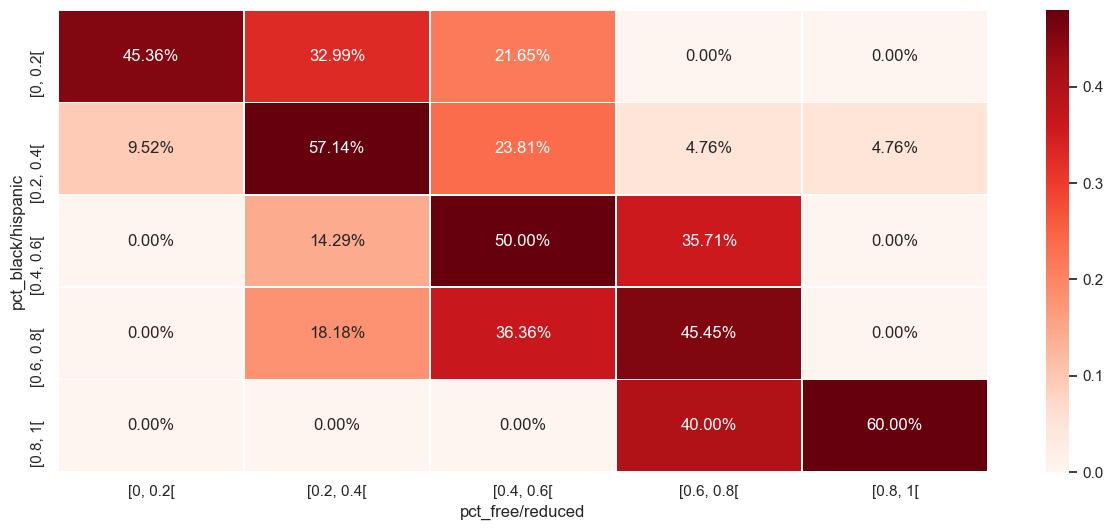

In [18]:
fr_hb_matrix = df_distr.groupby(['pct_black/hispanic',
            'pct_free/reduced']).size().unstack().fillna(0)


plt.figure(figsize = (15,6))
sns.set(font_scale=1)
sns.heatmap(matrix_normalize(fr_hb_matrix)
                ,annot= True, fmt = '.2%', linewidths=0.5
                ,vmax = 0.48
            , cmap = 'Reds'
           )
sns.set_style("darkgrid")
plt.show()

In [106]:
# ord_pp = [ '[4000, 6000[', '[6000, 8000[', '[8000, 10000[',
#  '[10000, 12000[', 
#  '[12000, 14000[', 
#  '[14000, 16000[', 
#  '[16000, 18000[',
#  '[18000, 20000[', 
#  '[20000, 22000[', 
#  '[22000, 24000[', 
#  '[32000, 34000[',
#       ]
# fr_hb_matrix = df_distr.groupby(['pct_black/hispanic',
#             'pp_total_raw']).size().unstack()[ord_pp].fillna(0)


# plt.figure(figsize = (15,6))
# sns.set(font_scale=1)
# sns.heatmap(matrix_normalize(fr_hb_matrix)
#                 ,annot= True, fmt = '.2%', linewidths=0.5
#                 ,vmax = 0.48
#             , cmap = 'Reds'
#            )
# sns.set_style("darkgrid")
# plt.show()

In [20]:
x = df_distr['state'].value_counts()
(x/x.sum())[:4].index

Index(['Connecticut', 'Utah', 'Massachusetts', 'Illinois'], dtype='object')

#### Products

In [21]:
len(df_eng.lp_id.unique()) ## --> 8647 products

8647

In [22]:
df_product.shape ## but we only have 372 data products details (top 372)

(372, 8)

In [23]:
len(set(df_eng.lp_id.unique()) - set(df_product['LP ID']))

8278

In [24]:
df_eng['has_lp_details'] = df_eng.lp_id.isin(df_product['LP ID']).astype(int)
df_eng2 = df_eng[df_eng.has_lp_details == 0]

In [25]:
df_eng2.shape[0]/df_eng.shape[0]

0.4762816926392402

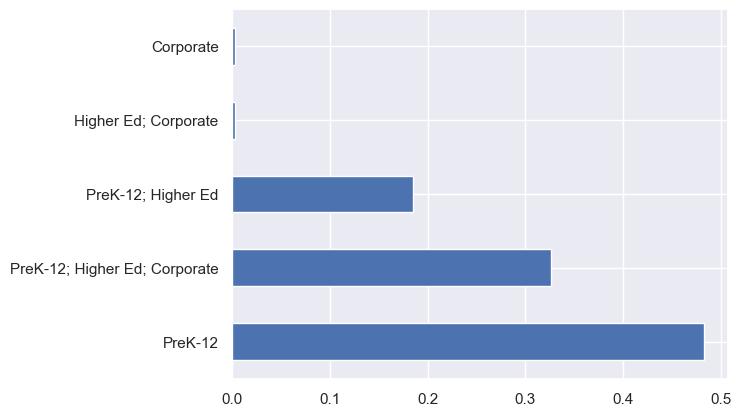

In [26]:
x = df_product['Sector(s)'].value_counts()
(x/x.sum()).plot(kind = 'barh')
plt.show()

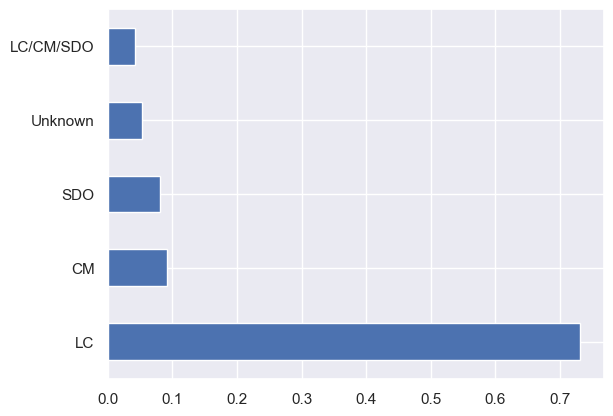

In [27]:
x = df_product['product_functions'].value_counts()
(x/x.sum()).plot(kind = 'barh')
plt.show()

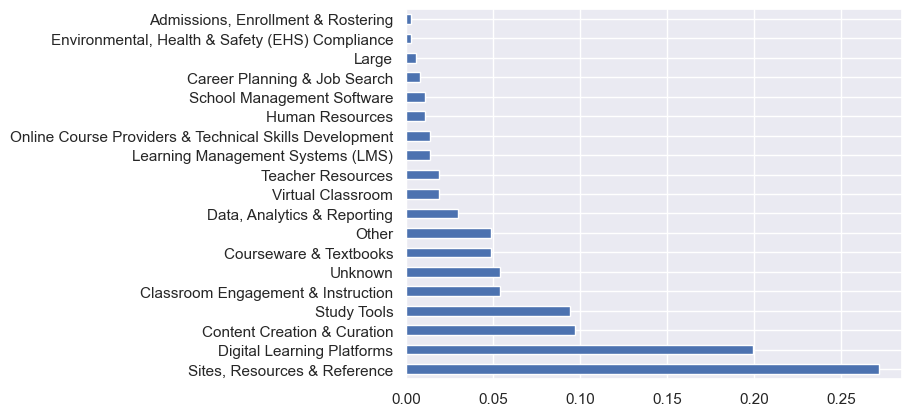

In [28]:
x = df_product['product_essential'].value_counts() ## --> one essential must have one function
(x/x.sum()).plot(kind = 'barh')
plt.show()

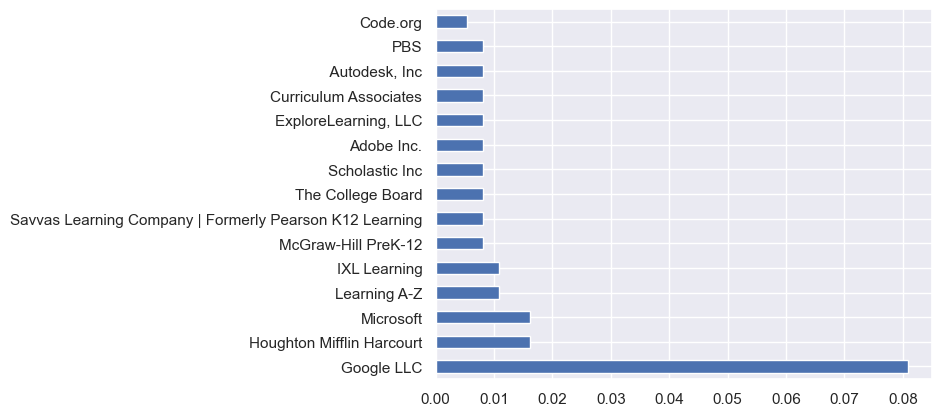

In [29]:
x = df_product['Provider/Company Name'].value_counts()
(x/x.sum())[:15].plot(kind = 'barh')
plt.show()

In [30]:
# del df_eng2

In [31]:
# funtion_essential_matrix = df_product.groupby(['product_essential',
#             'product_functions']).size().unstack().fillna(0)

# plt.figure(figsize = (15,8))
# sns.set(font_scale=1.15)
# sns.heatmap(matrix_normalize(funtion_essential_matrix)
#                 ,annot= True, fmt = '.2%', linewidths=0.5
#                 ,vmax = 0.48)

In [32]:
gc.collect()

40994

#### Engagements x covid case

In [63]:
df_daily_covid = pd.read_csv(BASE_PATH+'daily_covid_states.csv')
df_daily_covid['date'] = pd.to_datetime(df_daily_covid['date'])
df_daily_covid = df_daily_covid.sort_values('date')
df_daily_covid['case_shifted'] = df_daily_covid.groupby(['state'])['cases'].shift(1)
df_daily_covid['case_shifted'] = df_daily_covid['case_shifted'].fillna(0)
df_daily_covid['new_cases'] = df_daily_covid['cases'] - df_daily_covid['case_shifted']
df_daily_covid['new_cases'] = np.where(df_daily_covid['new_cases']<0,0,df_daily_covid['new_cases'])

In [34]:
df_eng.time.min(), df_eng.time.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [35]:
## Daily Pct Access regardless areas or product (Not Null)

## Most of time (more than 98%) less than 5% have at least one page load.
## But there is one day on particular areas (and source) have 100% access.

df_eng[df_eng['pct_access']>=0]['pct_access'].describe()

count    2.231074e+07
mean     5.042399e-01
std      3.180568e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e-02
75%      9.000000e-02
max      1.000000e+02
Name: pct_access, dtype: float64

In [36]:
df_eng['pct_access'].quantile(0.98)

4.85

In [68]:
df_eng2 = pd.merge(df_eng, df_distr[['district_id','state']], on ='district_id', how = 'left')
df_eng2 = pd.merge(df_eng2, df_daily_covid[['date','state','new_cases']], left_on = ['time','state'], right_on = ['date','state'],how = 'left')

In [78]:
day_size = df_eng.groupby('day').size()
day_unique_product = df_eng.groupby('day')['lp_id'].apply(pd.Series.nunique)
day_unique_areas = df_eng.groupby('day')['district_id'].apply(pd.Series.nunique)
day_daily_cases = df_eng2.groupby('day')['new_cases'].sum()
day_median_eng = df_eng.groupby('day')['engagement_index'].median()

In [64]:
# del df_eng_less5
# gc.collect()

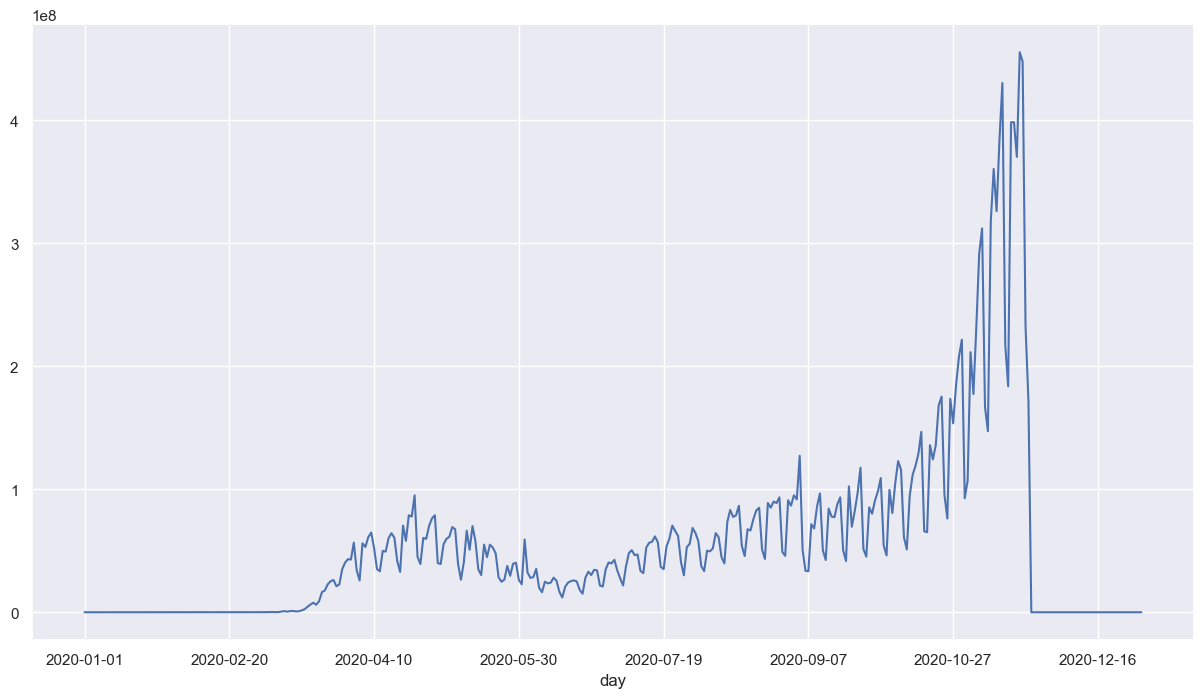

In [73]:
day_daily_cases.plot(figsize = (15,8))
plt.show()

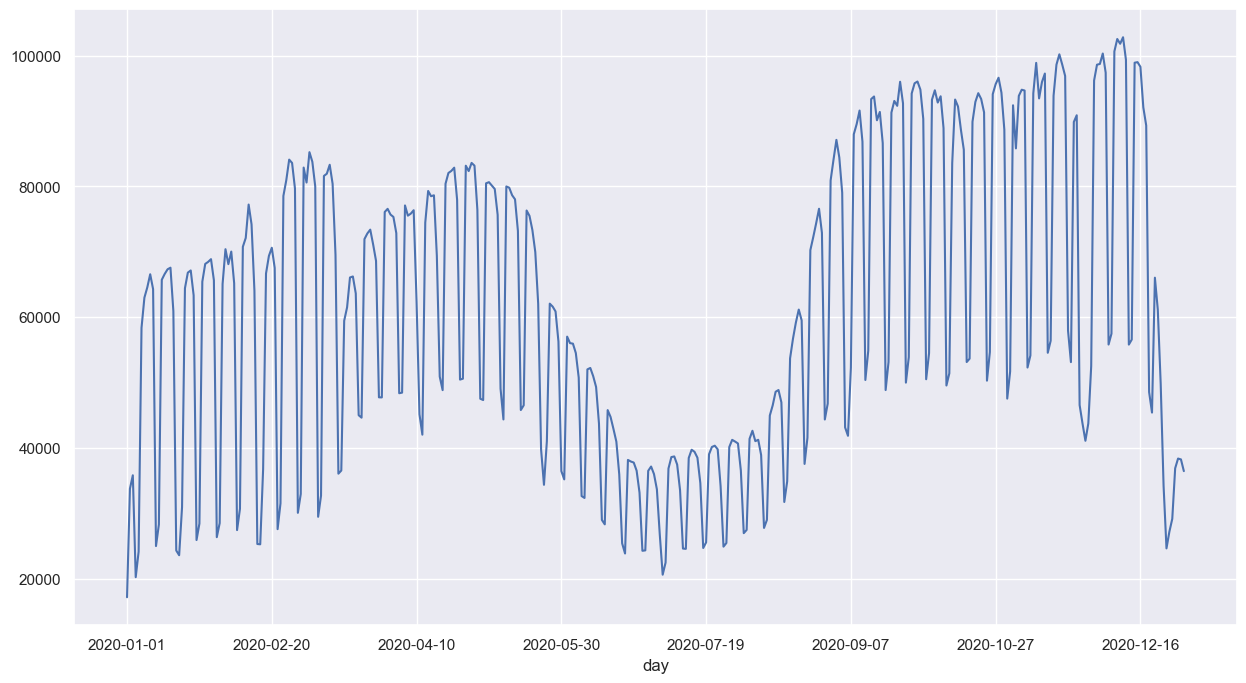

In [74]:
day_size.plot(figsize = (15,8))
plt.show()

In [75]:
# day_size['2020-05-01':'2020-05-15'].plot(figsize = (15,8))
# plt.show()

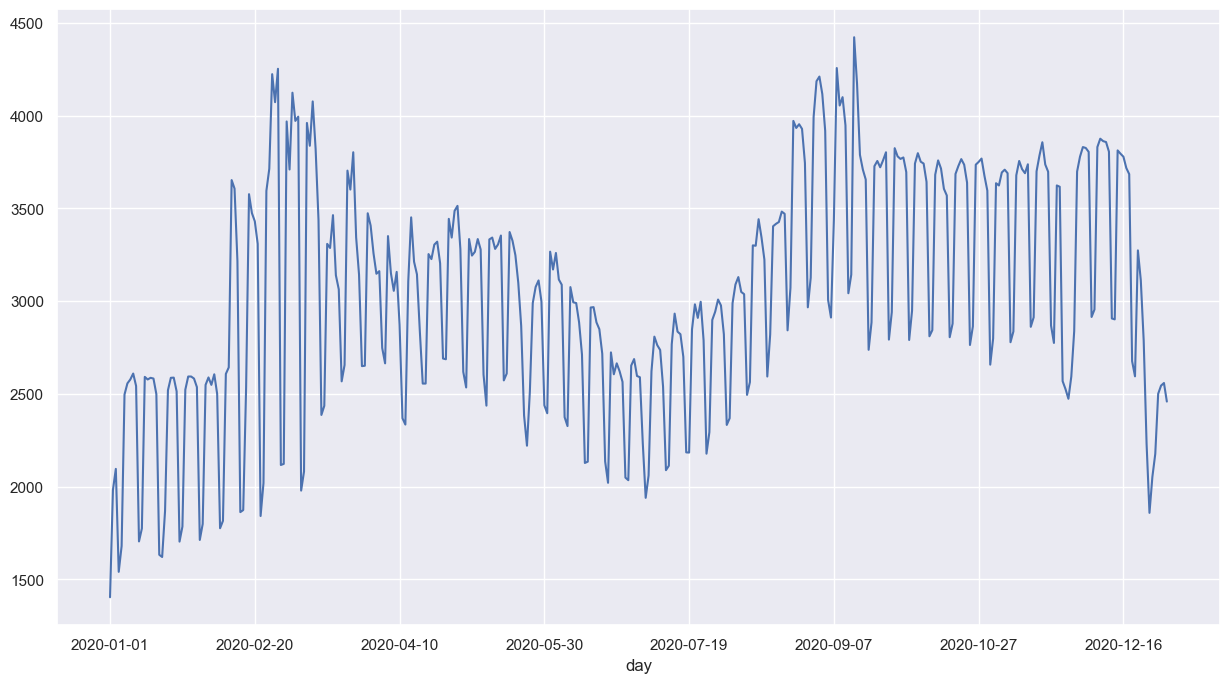

In [76]:
day_unique_product.plot(figsize = (15,8))
plt.show()

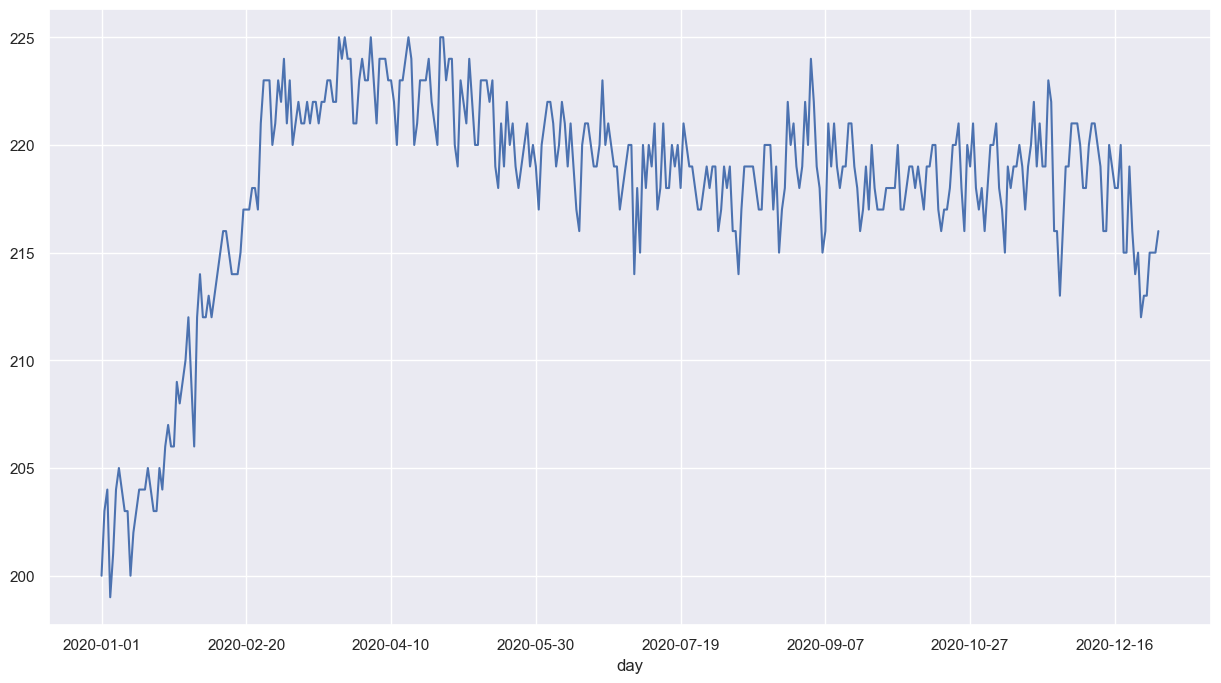

In [77]:
day_unique_areas.plot(figsize = (15,8))
plt.show()

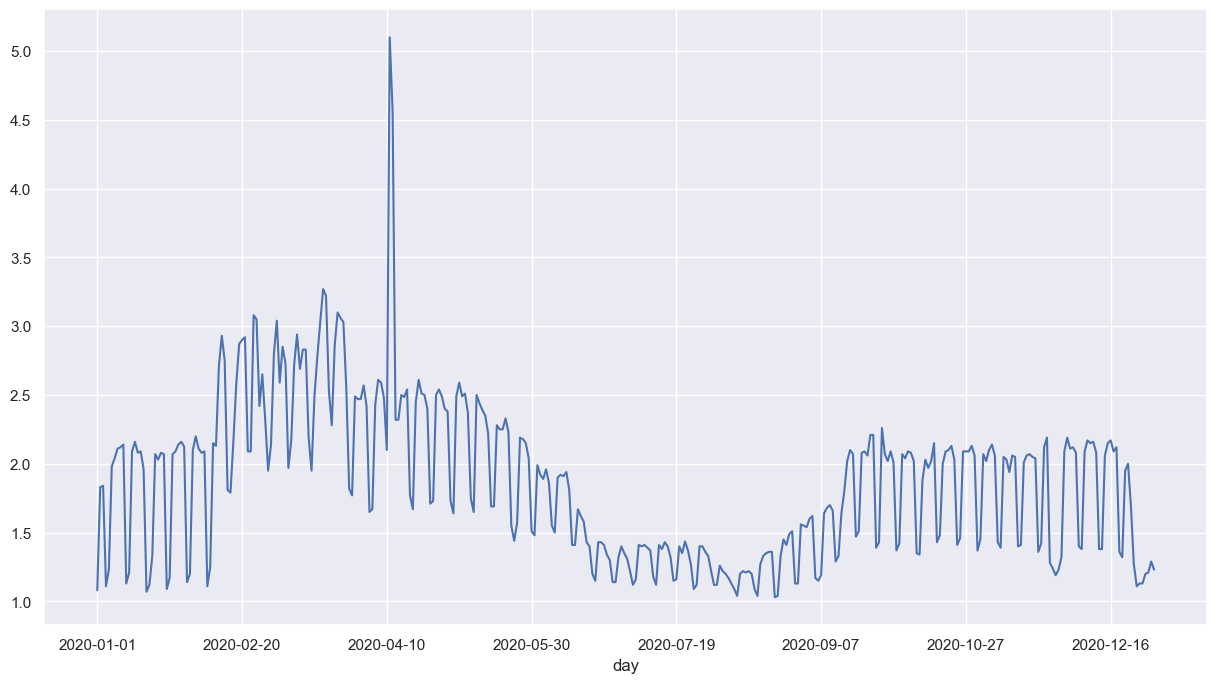

In [79]:
day_median_eng.plot(figsize = (15,8))
plt.show()

## Area Clustering <a class="anchor" id="second-bullet"></a>

In [80]:
df_eng_on = df_eng[df_eng.engagement_index > 0] 

In [81]:
df_district_summary1 = df_eng_on.groupby('district_id').agg({'day':pd.Series.nunique, 'lp_id': pd.Series.nunique, 
                                                   'engagement_index':np.mean})

In [82]:
df_district_summary1.head()

,day,lp_id,engagement_index
district_id,,,
1000,366,2303,192.102937
1039,366,1363,226.013791
1044,366,5143,88.548682
1052,366,2132,314.999440
1131,347,988,113.538369


In [83]:
len(df_district_summary1)

233

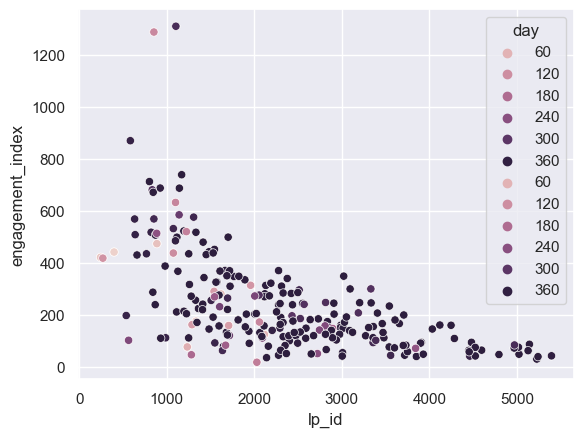

In [86]:
sns.scatterplot(data = df_district_summary1, x = 'lp_id', y = 'engagement_index', hue = 'day')
plt.show()

In [87]:
## Capping the engagement index
df_district_summary1.describe()

,day,lp_id,engagement_index
count,233.000000,233.000000,233.000000
mean,331.283262,2337.553648,238.959029
std,79.183803,1141.070304,190.676872
min,13.000000,245.000000,19.488887
25%,350.000000,1483.000000,113.174975
50%,366.000000,2205.000000,182.057322
75%,366.000000,3009.000000,312.204788
max,366.000000,5395.000000,1311.816298


In [88]:
df_district_summary1.engagement_index.quantile(0.95), df_district_summary1.lp_id.quantile(0.95)

(573.4923646943928, 4524.4)

In [89]:
df_district_summary1['engagement_index'] = np.where(df_district_summary1.engagement_index>600, 
                                        600, df_district_summary1.engagement_index)

df_district_summary1['lp_id'] = np.where(df_district_summary1.lp_id>4500, 
                                        4500, df_district_summary1.lp_id)

In [112]:
# ## KMeans
# ss_trf = StandardScaler()
# XX = df_district_summary1.values
# XX_s = ss_trf.fit_transform(XX)

# df_sil_score = pd.DataFrame()
# for j in range(10):
#     k_list = []
#     ss_list = []
#     for kk in [i+2 for i in range(10)]:
# #         k_clus_temp = KMeans(n_clusters = kk)
# #         k_clus_temp.fit(XX_s)
# #         clusters_temp = k_clus_temp.labels_
        
        
#         kclus_temp = SpectralClustering(n_clusters = kk, gamma = 0.8, n_init=25)
#         clustering_fit = kclus_temp.fit(XX_s)
#         clusters_temp = clustering_fit.labels_
        
#         k_list.append(kk)
#         ss_list.append(silhouette_score(XX_s,clusters_temp))
        
#         df_temp = pd.DataFrame({'k_list' : k_list, 'sil_score': ss_list})
#         df_sil_score = df_sil_score.append(df_temp)

# df_sil_score = df_sil_score.reset_index(drop = True)
# sns.boxplot(data = df_sil_score, x = 'k_list', y = 'sil_score')
# plt.vlines(x = 1, ymax=0.58, ymin = 0.32, colors='r')
# plt.show()

In [93]:
ss_trf = StandardScaler()
XX = df_district_summary1.values
XX_s = ss_trf.fit_transform(XX)

k_clus = KMeans(n_clusters = 3, random_state=100)
k_clus.fit(XX_s)
df_district_summary1['cls'] = k_clus.labels_

### Clusters Description

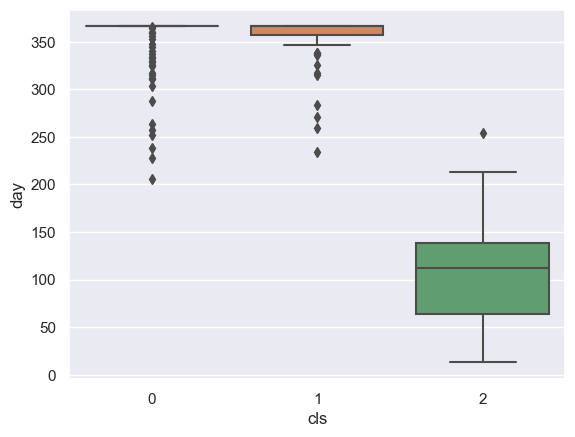

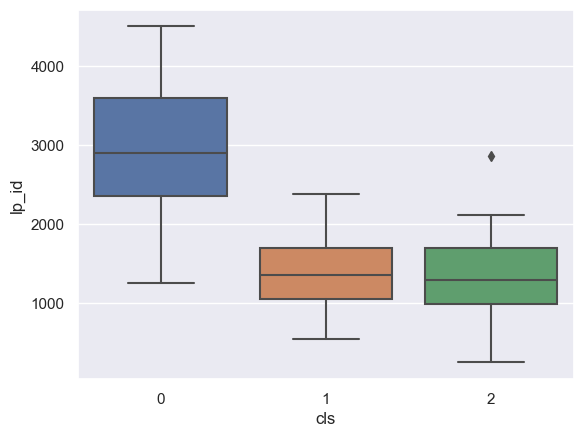

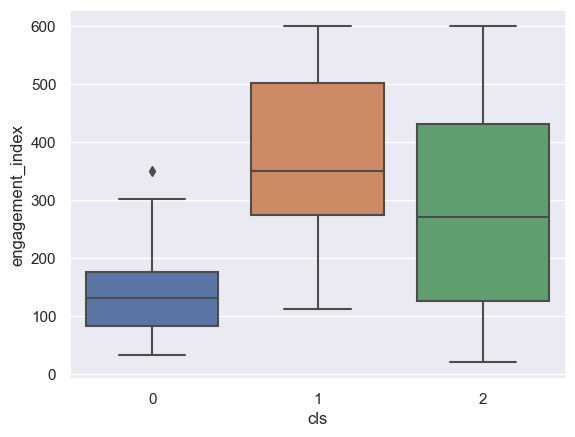

In [94]:
for c in ['day', 'lp_id', 'engagement_index']:
#     sorted_id = df_district_summary1.groupby('cls')[c].quantile(0.5).sort_values().index
    sorted_id = None
    sns.boxplot(data = df_district_summary1, x = 'cls', y = c, order=sorted_id)
    plt.show()

In [95]:
df_district_summary1.groupby('cls').size()

cls
0    134
1     76
2     23
dtype: int64

In [96]:
df_district_summary1.head()

,day,lp_id,engagement_index,cls
district_id,,,,
1000,366,2303,192.102937,0
1039,366,1363,226.013791,1
1044,366,4500,88.548682,0
1052,366,2132,314.999440,1
1131,347,988,113.538369,1


it seems, if areas is high product then it has low engagement. (so? any insight?)

There are 3 clusters :
* 0 --> high active day, high product (the Explorer)
* 1 --> high active day, low product (the Loyal)
* 2 --> low active day, low engagement (the Rookie)

In [115]:
# df_daily_covid.groupby('state').cases.max().

In [205]:
df_district_summary2 = df_district_summary1.reset_index()
df_distr_cls = pd.merge(df_distr, df_district_summary2[['district_id','cls']],
         on = ['district_id'], how = 'left')

df_distr_cls = pd.merge(df_distr, df_district_summary2[['district_id','cls']],
         on = ['district_id'], how = 'left')

df_distr_cls['inet_speed_grp'] = pd.cut(df_distr_cls.averageSpeed, [0,100,125,150,175,300], labels=['grp'+str(i) for i in range(5)])

In [206]:
def cluster_desc(col_check):
    hb_cls_mat = df_distr_cls.groupby([col_check,
                            'cls']).size().unstack().fillna(0)
    hb_cls_mat = matrix_normalize(hb_cls_mat, axis = 0).stack().reset_index()
    
    hb_cls_mat = hb_cls_mat.rename(columns = {0 : 'percent_size'})

    sns.barplot(data = hb_cls_mat ,x = col_check, y = 'percent_size', hue = 'cls')
    
    size_in_general = df_distr_cls.groupby(col_check).size()
    size_in_general = size_in_general/size_in_general.sum()
    k = 0
    for i in size_in_general:    
        plt.hlines(i,-0.3+k,0.3+k, color = 'r')
        k+=1
    plt.show()

the more pct free, the more probable to be cluster 0.

the more pct free, the least probable to be cluster 1.

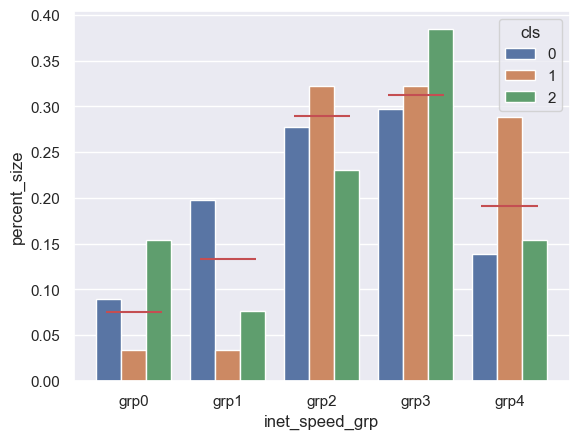

In [207]:
cluster_desc('inet_speed_grp')

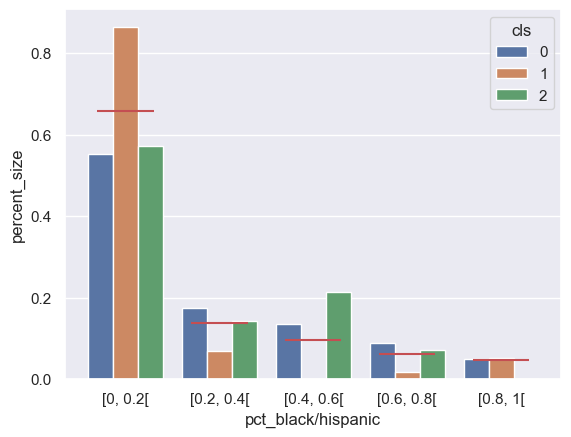

In [201]:
# cluster_desc('pct_free/reduced')
cluster_desc('pct_black/hispanic')

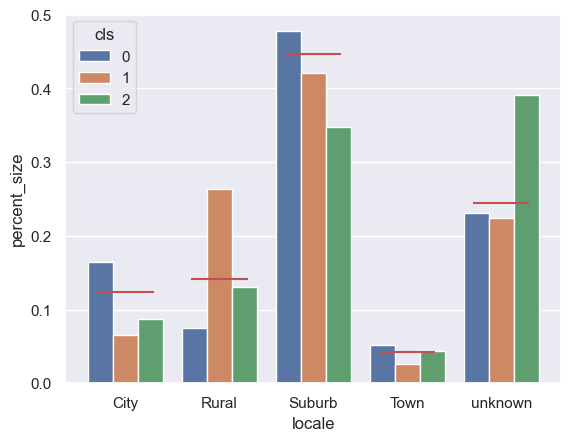

In [202]:
cluster_desc('locale')

In [203]:
# cluster_desc('pp_total_raw')

In [204]:
# df_distr_cls.groupby(['state','cls']).size().unstack().fillna(0)

In [104]:
del df_eng_on

In [105]:
gc.collect()

52432

## Platform Essentials <a class="anchor" id="third-bullet"></a>

In [82]:
df_time_only = df_eng[['day','weekday','is_weekend','weeks']].drop_duplicates().reset_index(drop=True)
df_time_only['rr'] = 1

df_district_only = df_eng[['district_id']].drop_duplicates().reset_index(drop=True)
df_district_only['rr'] = 1

df_base_district_time = pd.merge(df_time_only, df_district_only, on = 'rr').reset_index(drop=True)

In [83]:
def q50(x):
    return x.quantile(0.5)

In [119]:
def week_snapshot(wn, df_eng = df_eng, raw_base = False, website = False):
    title_f = 'snapshot learn platform week : '+wn
    df_week_temp = df_eng[df_eng.weeks == wn][['day','district_id',
                                            'lp_id','pct_access','engagement_index']]
    df_base_temp = df_base_district_time[df_base_district_time.weeks == wn]
    df_base_eng_temp = pd.merge(df_base_temp, df_week_temp, 
                     on = ['day','district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp = pd.merge(df_base_eng_temp, df_distr_cls[['district_id','cls']], 
                     on = ['district_id'], 
                     how = 'left'
                    )

    df_base_eng_temp['engagement_index2'] = np.where(df_base_eng_temp['engagement_index'] == 0, 1, 
                                                     df_base_eng_temp['engagement_index'].fillna(0)*1000)/100
    df_base_eng_temp['active_day'] =  np.where(df_base_eng_temp['engagement_index2'] != 0,df_base_eng_temp['day'],np.NaN)
    
    df_base_eng_temp = pd.merge(df_base_eng_temp, df_product, 
                     left_on = ['lp_id'], 
                     right_on = ['LP ID'],
                     how = 'left'
                    )
    
    if website :
        df_g1 = df_base_eng_temp.groupby(['cls','product_essential','URL']).agg({'engagement_index2':q50}).reset_index()
    else:
        df_g1 = df_base_eng_temp.groupby(['cls','product_essential']).agg({'engagement_index2':q50}).reset_index()
        df_g0 = df_base_eng_temp.groupby(['district_id','cls','product_essential']).agg({'LP ID':pd.Series.nunique}).reset_index()
        df_g2 = df_g0.groupby(['cls','product_essential']).agg({'LP ID':q50}).reset_index()
        df_g1 = pd.merge(df_g2, df_g1, on = ['cls','product_essential'])

    df_g1['week'] = wn
    if raw_base:
        return df_base_eng_temp, df_g1
    else:
        return pd.DataFrame, df_g1

In [123]:
df_weekly = pd.DataFrame()
wn_list = ['{:0>2}'.format(i+1) for i in range(45)]
for wn in wn_list:
    _,df_bb = week_snapshot(wn)
    df_weekly = df_weekly.append(df_bb)
df_weekly = df_weekly.reset_index(drop = True)

df_weekly2 = pd.DataFrame()
wn_list = ['{:0>2}'.format(i+1) for i in range(45)]
for wn in wn_list:
    _,df_bb = week_snapshot(wn, website=True)
    df_weekly2 = df_weekly2.append(df_bb)
df_weekly2 = df_weekly2.reset_index(drop = True)

In [124]:
df_weekly.head()

,cls,product_essential,LP ID,engagement_index2,week
0,0,"Admissions, Enrollment & Rostering",1.0,42.10,01
1,0,Career Planning & Job Search,3.0,45.25,01
2,0,Classroom Engagement & Instruction,12.0,2.40,01
3,0,Content Creation & Curation,25.0,13.10,01
4,0,Courseware & Textbooks,14.0,3.00,01


In [125]:
df_weekly2.head()

,cls,product_essential,URL,engagement_index2,week
0,0,"Admissions, Enrollment & Rostering",http://pearsoneasybridge.com/,42.1,01
1,0,Career Planning & Job Search,http://www.linkedin.com,5.8,01
2,0,Career Planning & Job Search,http://www.naviance.com/,304.7,01
3,0,Career Planning & Job Search,https://www.commonapp.org/,122.4,01
4,0,Classroom Engagement & Instruction,http://hapara.com/,2.0,01


In [116]:
## Get top essential
# metr = 'LP ID'
# feat = 'product_essential'

metr = 'engagement_index2'
feat = 'product_essential'
df_p50 = df_weekly.groupby([feat,'cls'])[metr].apply(q50).reset_index()
df_p50['RN'] = df_p50.groupby(['cls'])[metr].rank(method='dense', ascending=False).astype(int)
f_top = df_p50[df_p50['RN'] <= 3][feat].unique().tolist()
df_weekly_top = df_weekly[df_weekly[feat].isin(f_top)]
len(f_top)

6

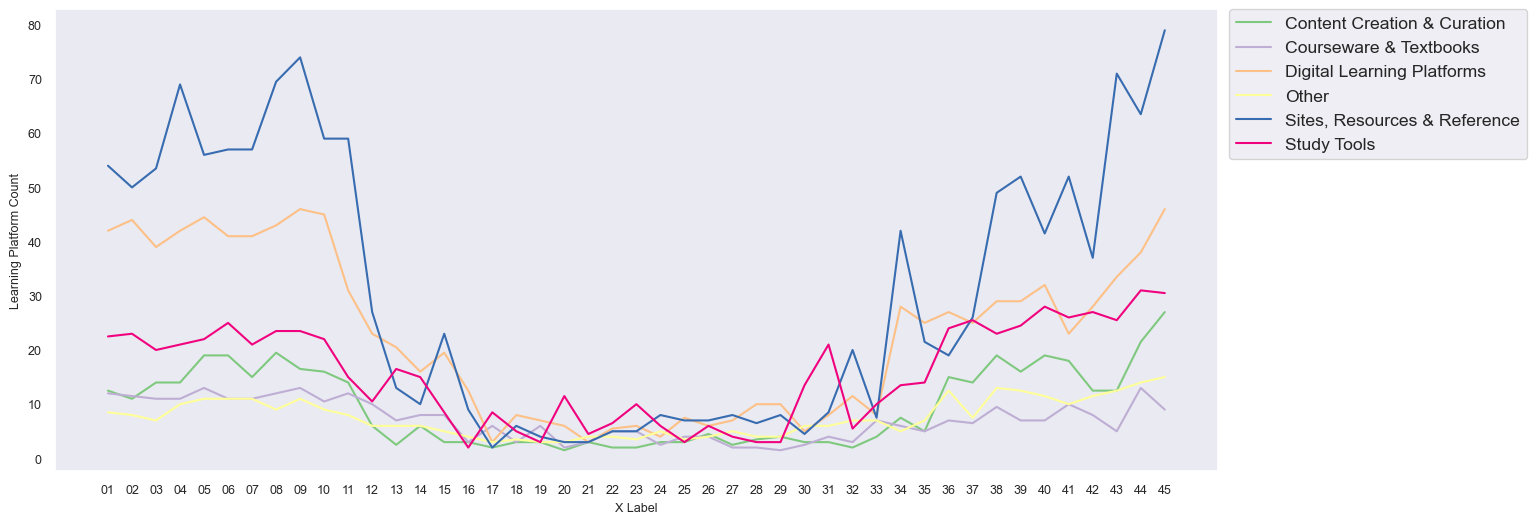

In [103]:
ess = essential_top3[0]
dtemp = df_weekly_top3[df_weekly_top3.product_essential == ess]

# sns.set_style("dark")
# plt.figure(figsize=(15,6))
# b =sns.lineplot(data = dtemp, x = 'week', y = 'LP ID', hue = 'cls', palette='bwr')
# legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# b.axes.set_title(ess,fontsize=12)
# b.set_xlabel("X Label",fontsize=9)
# b.set_ylabel("Learning Platform Count",fontsize=9)
# b.tick_params(labelsize=9)
# plt.show()


dtemp0 = df_weekly_top3[df_weekly_top3.cls == 2]
sns.set_style("dark")
plt.figure(figsize=(15,6))
b =sns.lineplot(data = dtemp0, x = 'week', y = 'LP ID', hue = 'product_essential', palette='Accent')
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# b.axes.set_title(,fontsize=12)
b.set_xlabel("X Label",fontsize=9)
b.set_ylabel("Learning Platform Count",fontsize=9)
b.tick_params(labelsize=9)
plt.show()

### 

In [ ]:
df_lp_p50[df_lp_p50['RN'] <= 3].sort_values(['cls','RN'])